# Notebook on Mean Convergence

Calculating the mean value of a field may be useful in CFD. However, the mean value obtained with experimental data might not be the exact value of the mean. It is possible to estimate the location of this value with a confidence interval. The idea is to create a range of values near the experimental mean and to estimate the probability of the real value to be in this range. The width of the range is linked to the number of experimental values and the confidence ratio you want to have in your interval.

Let us consider a signal (supposed converged) varying around a value following a determined repartition function. This signal is the one ploted hereafter. We will calculate its empirical mean value then we will compare it with the real expected value of the random variable to which it would have tended if the number of experimental values tend to infinty.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt("first_signal.txt", delimiter = ' ')
plt.plot(data)
plt.grid(True)

In [4]:
mean_value = np.mean(data)
print("The empirical mean value is %s." %(mean_value))

The empirical mean value is 16.63.


The mean value we get may be a good indicator of the real mean of our signal, but we have no idea of how far we might be from it.
So, how do we do in practice to estimate the mean value of a signal and the error made on this prediction?

Answer:   We use confidence intervals!

## Confidence intervals
Usually, when you have a set of values from a simulation, you do not have any idea of which repartition law are following your variables. You may although assume that they are following the same one of mean value $\mu$ and variance $\sigma^2$. The trick consists in finding a way to link your experimental results with a well known law: the normal law. How do we do that?

To make interval based estimations, we need an estimator of the parameter we are looking at and a law to rely on. As an example, the empirical mean $\overline{X}$ is a good estimator of the mean $\mu$. But for the moment, we do not have a law that we can base our interval on...


Let us consider the sum : $$S_N=\frac{1}{N}\sum _{i=1}^N X_i$$
The Central Limit Theorm (https://en.wikipedia.org/wiki/Central_limit_theorem) tells that, for a set of $N$
__independant__ variables following the same law:


$$\sqrt{N} \dfrac{(S_N-\mu)}{\sigma} \xrightarrow[N\to + \infty]{\mathcal{L}}\mathcal{N}(0,1)$$ 

with $\mu$ and $\sigma$ the real mean  and variance of your population and $\mathcal{N}(0,1)$ the centred reduced normal law.
The normal law is tabulated and it is possible to define a range of values in which the mean is included with a certain level of confidence.

On the other hand, we do not know the variance $\sigma$ of the law of $X$, the only thing we can do is to calculate the sample variance $s^2$: $$s^2=\dfrac{1}{N-1} \sum_{i=1}^N (X_i-\overline{X}_N)^2 \simeq \sigma^2,$$
We can estimate the error made on the empirical mean as it follows: $$|\epsilon|\leqslant z_{1-\alpha/2}\frac{\sigma}{\sqrt N}$$

where $\alpha$ is the error level, so if you want to be 95% sure the mean is in your interval, $\alpha$ should be 5 and your coefficients will be $z_{1-\alpha/2}=z_{0.975}$. Find the cell with the value 0.975 in the table and add the row and the column values to get the z value: 1.96.

Depending on the level of confidence you need the centred factor $z_{1-\alpha/2}$ will change according the values in the following table: [Gaussian PDF/coefficient](./Gaussian_distribution_table.png). 

In the end, the interval you will get will be: $[\overline{X_N}-1,96\dfrac{\sigma}{\sqrt{N}};\overline{X_N}+1,96\dfrac{\sigma}{\sqrt{N}}]$

In order to see the evolution of the confidence interval, we will calculate each time we add an experimental value the new mean of the signal and its variance.

In [5]:
def cumulative_values(vector):
    """Gives the cumulative mean and variance of a vector.
    
    The input of this function is a data vector. 
    The function takes the vector's first two values. 
    It calculates the mean of these two values and the variance of these values. 
    Then it takes the third value of the vector 
    and calculates the new variance, and so on...
    
    """
    
    cumulative_var = np.zeros(len(vector))
    iterations = np.arange(0, len(vector), 1)
    cumul = np.cumsum(vector)
    cumulative_mean = cumul / np.arange(1, len(cumul) + 1)
    for i in range(1, len(vector)):
        square_diff = (vector[:i] - cumulative_mean[i]) ** 2
        cumulative_var[i] = np.mean(square_diff[:])
    return cumulative_var, cumulative_mean

We also define the function which will calculate the confidence interval.

In [6]:
def mean_interval(signal, z_value):
    """Gives the confidence interval of the mean of the vector.
    
    This function calculates the confidence interval 
    around the mean of the values of a vector.
    Its inputs are the vector itself and the coefficient 
    corresponding to the normal tables coefficient
    
    """

    lower_limit = np.ones_like(signal)
    higher_limit = np.ones_like(signal)
    variance, mean = cumulative_values(signal)
    lower_limit = mean - z_value * np.sqrt(variance)/np.sqrt(np.arange(1,len(signal) + 1, 1))
    higher_limit = mean + z_value * np.sqrt(variance)/np.sqrt(np.arange(1,len(signal) + 1, 1))

    fig = plt.figure()
    ax = fig.add_subplot(211)
    plt.title('Original signal')
    ax.plot(signal, 'b')
    plt.grid(True)
    plt.subplots_adjust(top=2)
    plt.subplot(212)
    plt.title('Mean evolution with increasing number of samples')
    plt.plot(mean, 'b', markersize=1)
    plt.plot(lower_limit, '--r')
    plt.plot(higher_limit, '--r')
    plt.grid(True)

    print("The experimental mean value is %s and the standard deviation is %s" 
             %(mean[-1], np.sqrt(variance[-1])))
    print("There is 95" + '%' + " chance the mean is in the interval [%s ; %s] " 
             %(float(lower_limit[-1]), float(higher_limit[-1])))
    return mean, higher_limit

Now we generate a random vector following a normal distribution of unknown mean and variance and we use the function we have just created to estimate the mean.

The experimental mean value is 0.8108652817923255 and the standard deviation is 0.4016730779064665
There is 95% chance the mean is in the interval [0.8029924894653588 ; 0.8187380741192922] 
10000 10000


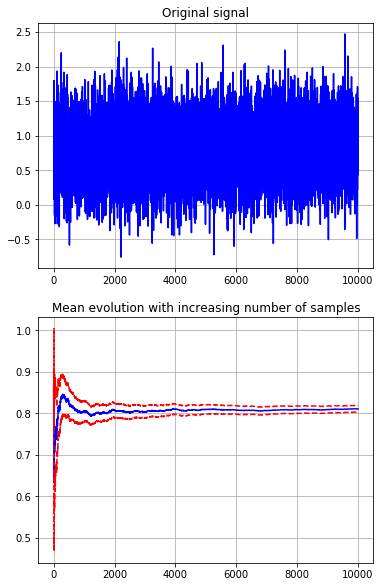

In [7]:
normal_distibuted_vector = np.random.normal(np.random.rand(1), np.random.rand(1), 10000)
mean_normal_distibution, higher_bounds = mean_interval(normal_distibuted_vector, 1.96)
print(len(mean_normal_distibution),len(higher_bounds))

We can now evaluate the relative error made on the mean and plot it as a function of the number of samples.

In [8]:
def calculate_relative_error(mean_of_the_signal):
    """Gives the relative error on the empirical mean.
    
    This function calculates the relative error on the empirical mean
    and a the real one considered included in the confidence interval.
    
    """
    
    relative_error = np.zeros(len(mean_of_the_signal))
    for i, value in enumerate(mean_of_the_signal):
        real_mean = mean_of_the_signal[-1]
        relative_error[i] = (higher_bounds[i] - mean_of_the_signal[i]) / real_mean
    
    plt.plot(relative_error)
    plt.grid(True)
    plt.title('Relative error on the mean')
    plt.xlim(1, len(relative_error))
    plt.loglog()

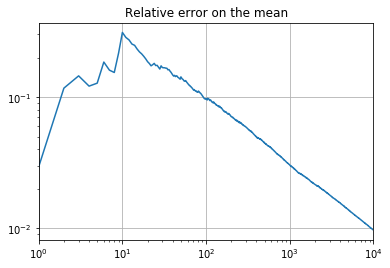

In [9]:
calculate_relative_error(mean_normal_distibution)

We see on this plot that increasing the number of samples leads us to a decrease of ratio $\dfrac{1}{\sqrt{N}}$ on the error made on the mean. That means that if you want to go from an error of 0.1 to an error of 0.01, you must multiply by 100 your number of samples!

Now, if we apply what we have just learned on our first example let us see what are the results we obtain:

The experimental mean value is 16.63 and the standard deviation is 4.436388899166355
There is 95% chance the mean is in the interval [15.760467775763393 ; 17.499532224236603] 


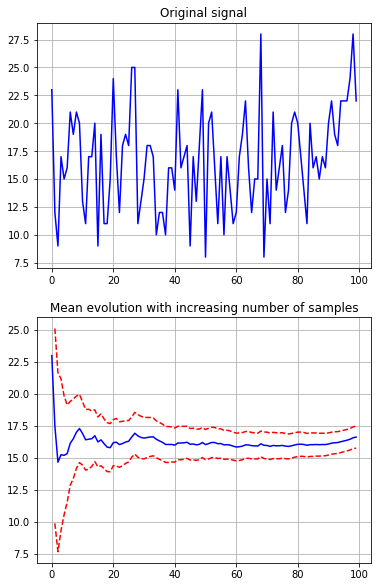

In [51]:
data_mean, higher_limit = mean_interval(data, 1.96)